In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [116]:
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

## Učitavanje i analiza podataka

In [2]:
train_data = pd.read_csv('csv/train.csv')

In [3]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_data = pd.read_csv('csv/test.csv')

In [5]:
train_data.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [6]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
train_data.shape, test_data.shape

((159571, 8), (153164, 2))

In [73]:
#train_data[train_data['toxic'] == 1]

Provera da li ima nedostajućih vrednosti:

In [8]:
train_data.isnull().values.any()

False

Nema nedostajućih vrednosti - sve vrednosti su ili 0 ili 1

In [9]:
print(train_data['toxic'].unique()) 
print(train_data['severe_toxic'].unique())
print(train_data['obscene'].unique())
print(train_data['insult'].unique())
print(train_data['threat'].unique())
print(train_data['identity_hate'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Izdvajanje klasa

In [11]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
categories = train_data[classes]

In [12]:
categories.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


### Broj komentara po kategorijama

In [13]:
freq_per_class = categories.sum()

In [14]:
freq_per_class

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Grafički prikaz zastupljenosti različitih vrsta komentara

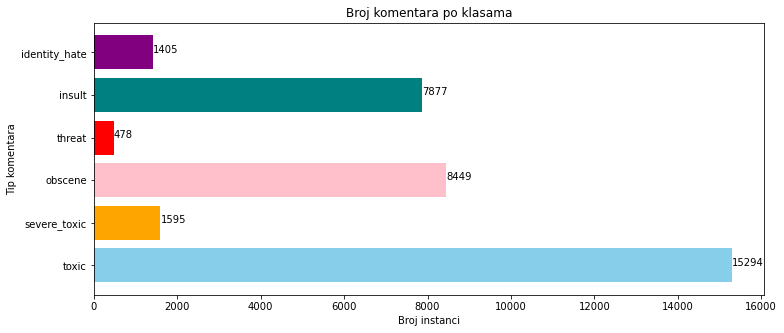

In [16]:
colors = ['skyblue', 'orange', 'pink', 'red', 'teal', 'purple', 'khaki']

plt.figure(figsize=(12,5))
plt.barh(freq_per_class.index, freq_per_class, color = colors)
for index, value in enumerate(freq_per_class):
    plt.text(value, index, str(value))

plt.xlabel('Broj instanci')
plt.ylabel('Tip komentara')
plt.title('Broj komentara po klasama')
plt.savefig('img/01_frequency_bar.png', orientation='landscape')

plt.show()

Broj komentara klasifikovanih u više od jedne klase:

1    6360
2    3480
3    4209
4    1760
5     385
6      31
dtype: int64


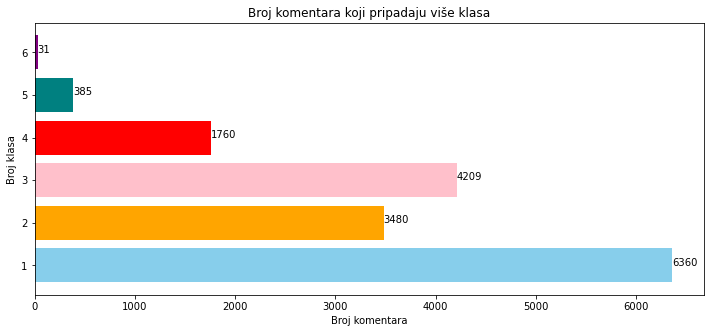

In [17]:
class_sums = train_data.iloc[:, 2:].sum(axis = 1)
counts = class_sums.value_counts().sort_index()
counts = counts.iloc[1:]
print(counts)

plt.figure(figsize=(12,5))
plt.barh(counts.index, counts.values, color = colors)
for index, value in enumerate(counts.values):
    plt.text(value, index+1, str(value))

plt.xlabel('Broj komentara')
plt.ylabel('Broj klasa')
plt.title('Broj komentara koji pripadaju više klasa')
plt.savefig('img/03_multilabel_freq.png', orientation='landscape')

plt.show()

Dakle, najviše komentara pripada samo jednoj klasi, a 31 komentar ispunjava uslove za svaku od 6 klasa (istovremeno je toxic, severe_toxic, insult, obscene, threat i identity hate)

Udeo neklasifikovanih komentara u celom trening skupu:

In [18]:
not_labeled_count= class_sums.value_counts()[0]
print('Broj neoznacenih komentara: ', not_labeled_count)
print('Broj ukupnih komentara: ', train_data.shape[0])
percent_not_labeled = not_labeled_count/train_data.shape[0]
print('Udeo neoznacenih komentara:  {:.2%}'.format(percent_not_labeled))

Broj neoznacenih komentara:  143346
Broj ukupnih komentara:  159571
Udeo neoznacenih komentara:  89.83%



 ####  Samo oko 10% skupa je klasifikovano kao toksično, ostatak su komentari koji se smatraju 'čistim' - NEBALANSIRAN SKUP

In [19]:
percents = [round(p/train_data.shape[0]*100, 2) for p in freq_per_class]
percents.append(round(percent_not_labeled*100,2))

legend = freq_per_class.index.values.tolist()
legend.append('not_labeled')

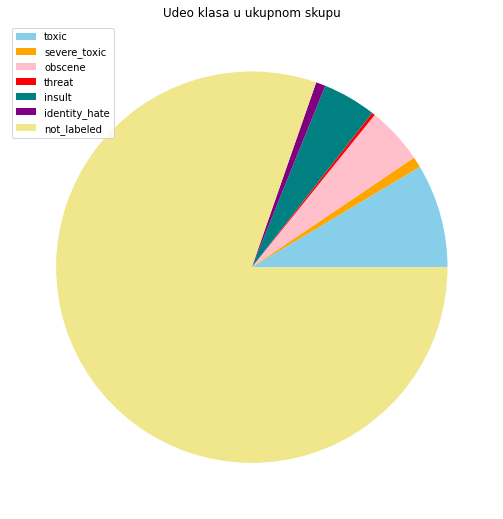

In [21]:
plt.figure(figsize=(9,9))
plt.pie(percents, colors = colors)
plt.legend(legend, loc='upper left')
plt.title('Udeo klasa u ukupnom skupu')
plt.savefig('img/02_class_distribution.png')

plt.show()

#### Napomena: Balansiranje podataka je odrađeno u narednoj svesci.

## Priprema teksta

In [22]:
# Podaci izdvojeni za svaku klasu:

toxic = train_data[train_data.toxic==1]
severe_toxic = train_data[train_data.severe_toxic==1]
obscene = train_data[train_data.obscene==1]
threat = train_data[train_data.threat == 1]
insult = train_data[train_data.insult==1]
identity_hate = train_data[train_data.identity_hate==1]
not_labeled = train_data[train_data[classes].eq(0).all(1)]

### Najčešće reči po klasama

In [23]:
# fja koja vraca string naziva data frame-a

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [24]:
def get_wordcloud(comment_type):
    df = comment_type
    words = ' '.join([text for text in df['comment_text'] ])

    wordcloud = WordCloud(width=2500,
                      height=1600,
                      max_words=500,
                      collocations=False,
                      stopwords=STOPWORDS).generate(words)

    name = get_df_name(df)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(name + ' wordcloud')
    plt.savefig('img/wordclouds/' + name + '.png')
    plt.show()

### Wordcloud za svaku od klasa

Slike sa oblacima reči za svaku od klasa: https://github.com/Anakin2012/ToxicCommentClassificationChallenge/tree/main/img/wordclouds

In [25]:
#get_wordcloud(not_labeled)
#get_wordcloud(toxic)
#get_wordcloud(severe_toxic)
#get_wordcloud(obscene)
#get_wordcloud(insult)
#get_wordcloud(identity_hate)
#get_wordcloud(threat)

In [26]:
# wordcloud za test skup

#get_wordcloud(test_data)

Izbacivanje nepotrebnih karaktera
https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

In [28]:
train_data['comment_text']

0         Explanation\r\nWhy the edits made under my use...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\r\nMore\r\nI can't make any real suggestions...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \r\n\r\nThat...
159568    Spitzer \r\n\r\nUmm, theres no actual article ...
159569    And it looks like it was actually you who put ...
159570    "\r\nAnd ... I really don't think you understa...
Name: comment_text, Length: 159571, dtype: object

In [29]:
def remove_irrelevant(df):
    
    df['comment_text'] = df['comment_text'].str.lower()
    df['comment_text'] = df['comment_text'].str.replace(r"https?:\/\/.*[\r\n]*", "")
    df['comment_text'] = df['comment_text'].str.replace(r"\d+", "")
    df['comment_text'] = df['comment_text'].str.replace(r"[\n\r\t]", " ")
    df['comment_text'] = df['comment_text'].str.replace(r"[^A-Za-z0-9(),]", " ")
    df['comment_text'] = df['comment_text'].str.replace(r"@\S+", "")
    
    return df

Izbacivanje stop-reči

In [30]:
sw = stopwords.words('english')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [31]:
def remove_stopwords(sentence):
    
    sw_list = stopwords.words('english')
    words = [word for word in sentence.split() if word not in sw_list]
    new_sentence = " ".join(words)
    
    return new_sentence

Stemovanje i lematizacija
https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

In [32]:
stemmer = SnowballStemmer("english")
wnl = WordNetLemmatizer()


def stem(sentence):
    new_sentence = ""
    for word in sentence.split():
        stem = wnl.lemmatize(word) if (wnl.lemmatize(word).endswith('e') or wnl.lemmatize(word).endswith('y')) else stemmer.stem(word)
        #stem = stemmer.stem(word)
        new_sentence += stem
        new_sentence += " "

    new_sentence = new_sentence.strip()
    return new_sentence

In [33]:
new_train = train_data
new_test = test_data

In [34]:
def transform_text(df):

    remove_irrelevant(df)
    df['comment_text'] = df['comment_text'].apply(remove_stopwords)
    df['comment_text'] = df['comment_text'].apply(stem)

In [35]:
transform_text(new_train)
transform_text(new_test)

<ipython-input-29-4c48b8e1fca3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment_text'] = df['comment_text'].str.replace(r"https?:\/\/.*[\r\n]*", "")
<ipython-input-29-4c48b8e1fca3>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment_text'] = df['comment_text'].str.replace(r"\d+", "")
<ipython-input-29-4c48b8e1fca3>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment_text'] = df['comment_text'].str.replace(r"[\n\r\t]", " ")
<ipython-input-29-4c48b8e1fca3>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment_text'] = df['comment_text'].str.replace(r"[^A-Za-z0-9(),]", " ")
<ipython-input-29-4c48b8e1fca3>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment_text'] = df['comment_text'].str.replace(r

Tekst komentara nakon svih transformacija izgleda ovako:

In [36]:
new_train['comment_text'].head()

0    explan edit made username hardcore metallica f...
1    aww match background colour seemingly stuck th...
2    hey man, really tri edit war guy constantly re...
3    make real suggest improv wonder section statis...
4                    you, sir, hero chance rememb page
Name: comment_text, dtype: object

In [38]:
new_test['comment_text'].head()

0    yo bitch ja rule succes ever what hate sad mof...
1                               rfc title fine is, imo
2                           source zawe ashton lapland
3    look back source, inform updat correct form gu...
4                             anonymously edit article
Name: comment_text, dtype: object

Da li postoje prazni komentari?

In [41]:
new_train[new_train['comment_text']== '']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
228,0091798f05a311af,,0,0,0,0,0,0
329,00d300b2a1d61c1c,,0,0,0,0,0,0
3699,09e4ea8663421151,,0,0,0,0,0,0
3990,0aa6f3529219b37e,,0,0,0,0,0,0
4217,0b3eadc48e6dac06,,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
156776,d3741a61f9c91ac0,,0,0,0,0,0,0
158092,e8a55975186094fe,,0,0,0,0,0,0
158123,e919900bd9def7c1,,0,0,0,0,0,0
159019,f76021a84e196d98,,0,0,0,0,0,0


Izbacivanje 159 redova koji sadrže prazne komentare:

In [43]:
new_train.shape

(159571, 8)

In [49]:
new_train = new_train[new_train['comment_text'] != '']
new_train.shape

(159412, 8)

Datoteka test.csv - podaci koji su se na takmičenju koristili za proveru. Spajanje kolona i izbacivanje onih koje se ne koriste (sadrže -1 na mestu klase)

In [58]:
test_labels = pd.read_csv('csv/test_labels.csv')

test_text = new_test['comment_text'].values.astype('U')

unseen_data = pd.merge(new_test,test_labels,on="id")
unseen_data = unseen_data[unseen_data["toxic"] != -1]
unseen_data = unseen_data[unseen_data["comment_text"] != '']

In [61]:
unseen_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,thank understand think highly would revert wit...,0,0,0,0,0,0
7,000247e83dcc1211,dear god site horrible,0,0,0,0,0,0
11,0002f87b16116a7f,somebody invariably try add religion really me...,0,0,0,0,0,0
13,0003e1cccfd5a40a,say right type type institut need case three l...,0,0,0,0,0,0
14,00059ace3e3e9a53,"ad new product list, make sure relev ad new pr...",0,0,0,0,0,0


In [62]:
unseen_data.shape

(63641, 8)

Čuvamo u nove csv fajlove filtrirane podatke

In [63]:
#new_train.to_csv('csv/data_filtered.csv', index = False)
#unseen_data.to_csv('csv/unseen_filtered', index = False)

### Balansiranje
Problem nebalansiranog skupa podataka rešavamo koristeći undersampling.

In [84]:
def balance_data(data):
    classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    largest_class_size = (data[classes].sum()).max()
    unclassified_data = data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)] 
    dropped_rows = unclassified_data.sample(unclassified_data.shape[0] - largest_class_size)
    data_balanced = data[~data['id'].isin(dropped_rows['id'])]
    return data_balanced

In [85]:
new_train.shape

(159412, 8)

In [89]:
balanced_data = balance_data(new_train)
print('Broj podataka nakon balansiranja: ', balanced_data.shape[0])

Broj podataka nakon balansiranja:  31503


In [90]:
balanced_data.to_csv('csv/data_balanced.csv', index = False)